In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 32 Lecture 1 Assignment

In this assignment, we will learn about K nearest neighbor regression. We will use the absenteeism at work dataset loaded below and analyze the model generated for this dataset.

The meaning of the different columns can be found here: https://www.kaggle.com/tonypriyanka2913/employee-absenteeism

In [2]:
import warnings

import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
pd.options.display.max_columns = 50

<IPython.core.display.Javascript object>

In [4]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [5]:
absent = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Absenteeism_at_work.csv",
    sep=";",
)

<IPython.core.display.Javascript object>

In [6]:
absent.shape

(740, 21)

<IPython.core.display.Javascript object>

In [7]:
absent.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


<IPython.core.display.Javascript object>

In [8]:
absent = absent.drop(columns="ID")

<IPython.core.display.Javascript object>

In [9]:
bin_cols = ["Disciplinary failure", "Social drinker", "Social smoker"]

# 'Month of absence', 'Day of the week', 'Seasons' are tricky
# In context of missing work:
#   * i think friday/monday are similar, but this ordinal encoding
#     makes those days more different
#   * consider that month as a number makes jan/dec far away, do we
#     want this in this case? idk if there's an obvious answer
#   * prolly best as one hot

cat_cols = ["Reason for absence", "Seasons", "Month of absence", "Day of the week"]
drop_cats = [0, 4, 0, 2]

num_cols = [
    "Transportation expense",
    "Distance from Residence to Work",
    "Service time",
    "Age",
    "Work load Average/day ",
    "Hit target",
    "Education",
    "Son",
    "Pet",
    "Height",
    "Body mass index",
]

<IPython.core.display.Javascript object>

Find which variables have the highest pairwise correlation and remove them from our dataset. Additionally, try to think of which variables are correlated by looking at the column names and remove those columns as well.

Note: When choosing between two categorical variables that are correlated, you often want to keep the one with fewer unique values. Why might that be? (Think about the cons of KNN.)

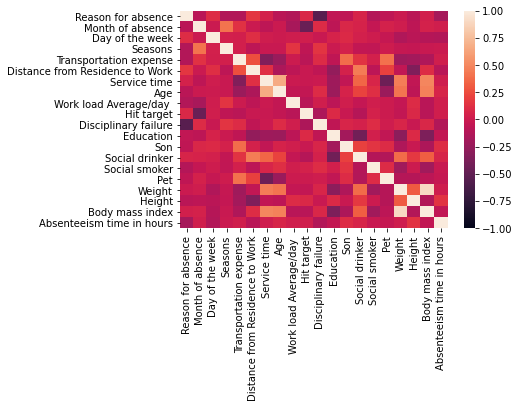

<IPython.core.display.Javascript object>

In [10]:
sns.heatmap(absent.corr(), vmin=-1, vmax=1)
plt.show()

Split the data into train and test with test containing 20% of the data, then scale your features.

In [11]:
# Removing rare categories
counts = absent["Reason for absence"].value_counts()
counts = counts[counts > 3]
keep_reasons = counts.index

absent = absent[absent["Reason for absence"].isin(keep_reasons)]

<IPython.core.display.Javascript object>

In [12]:
X = absent.drop(columns=["Absenteeism time in hours", "Weight"])

# Use this to use raw y
y = absent["Absenteeism time in hours"]

# Use this to apply a log transform to y (+1 to avoid 0 cases)
y = np.log(absent["Absenteeism time in hours"] + 1)

<IPython.core.display.Javascript object>

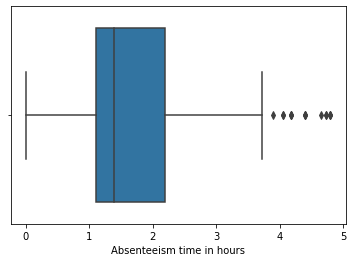

<IPython.core.display.Javascript object>

In [13]:
sns.boxplot(y)
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [15]:
print_vif(X_train)

VIF results
-------------------------------
const                              2691.639995
Reason for absence                    1.571139
Month of absence                      1.759155
Day of the week                       1.109252
Seasons                               1.355879
Transportation expense                1.795324
Distance from Residence to Work       2.442392
Service time                          3.355301
Age                                   2.371558
Work load Average/day                 1.235191
Hit target                            1.487557
Disciplinary failure                  1.548466
Education                             1.494383
Son                                   1.431751
Social drinker                        2.595073
Social smoker                         1.166927
Pet                                   1.671324
Height                                1.680965
Body mass index                       1.955876
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [16]:
preprocessing = ColumnTransformer(
    [
        ("dummy", OneHotEncoder(drop=drop_cats), cat_cols),
        ("scale", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [17]:
pipeline = Pipeline([("preprocessing", preprocessing), ("knn", KNeighborsRegressor())])

<IPython.core.display.Javascript object>

Train a series of KNN regression models with a range of K values. For each K value, use cross validation of the training set and find the average RMSE score. Make a plot of K versus average RMSE. What is the best value of K?

In [18]:
ks = np.arange(1, 100, 2)
rmses = []

for k in ks:
    pipeline.named_steps["knn"].n_neighbors = k
    neg_rmses = cross_val_score(
        pipeline, X_train, y_train, scoring="neg_root_mean_squared_error"
    )
    avg_rmse = np.mean(-neg_rmses)
    rmses.append(avg_rmse)

<IPython.core.display.Javascript object>

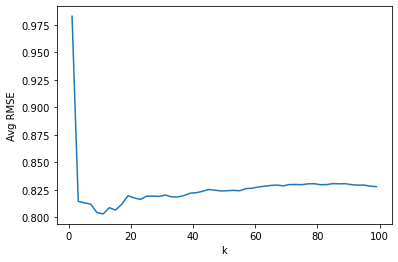

<IPython.core.display.Javascript object>

In [19]:
plt.plot(ks, rmses)
plt.xlabel("k")
plt.ylabel("Avg RMSE")
plt.show()

Using your best K, fit a model to all your training data and show the RMSE for the training and testing sets.

In [20]:
grid = {"knn__n_neighbors": np.arange(1, 100, 4)}
model = GridSearchCV(pipeline, grid)
model.fit(X_train, y_train)

model.best_params_

{'knn__n_neighbors': 9}

<IPython.core.display.Javascript object>

In [21]:
model.score(X_train, y_train)

0.27333978929548597

<IPython.core.display.Javascript object>

In [22]:
model.score(X_test, y_test)

0.14448170915016856

<IPython.core.display.Javascript object>

In [23]:
y_pred = model.predict(X_test)

# Use this to use raw y
y = absent["Absenteeism time in hours"]

# Use this if log transform applied to y
resid = np.exp(y_pred) - np.exp(y_test)

<IPython.core.display.Javascript object>

In [24]:
mae = np.mean(np.abs(resid))
mae

5.655628530520375

<IPython.core.display.Javascript object>

This code assumes a log transform was applied.  We're very poor at predicting the extreme values.  More investigation of those records should be done.  Are the very atypical and out of scope based on that? Are there other predictors we could use?

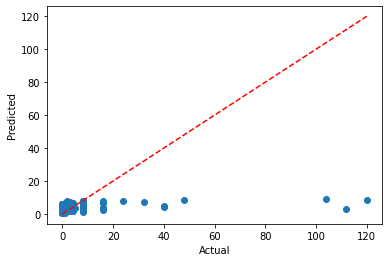

<IPython.core.display.Javascript object>

In [25]:
y_test = np.exp(y_test) - 1
y_pred = np.exp(y_pred) - 1

mn = y_test.min()
mx = y_test.max()

plt.scatter(y_test, y_pred)
plt.plot([mn, mx], [mn, mx], "--", c="red")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()